In [1]:
import pandas as pd
import numpy as np 
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


os.listdir("../input/")
basepath = "../input/siim-isic-melanoma-classification/"
modelspath = "../input/pytorch-pretrained-image-models/"

In [2]:
def map_imgs(meta_file_path, image_file_path):
    IMAGE_PATH = image_file_path
#     meta_file= '/kaggle/input/siim-isic-melanoma-classification/train.csv'
#     IMAGE_PATH = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
    
    df = pd.read_csv(meta_file_path)

    # adding new column = filepath (complete image path)
    df['image_path'] = df['image_name'].map(lambda x:  os.path.join(IMAGE_PATH,x+'.jpg'))

    # mapping dictionary
    labelmap = {}
    for l in df.target.unique().tolist():
        if l == 1:
            labelmap[l] = 'melanoma'
        else:
            labelmap[l] = 'benign'

    # seperate list of image that are labelled = melanoma
    df_melanoma = df[df['target'] == 1]
    df_melanoma.reset_index(drop=True, inplace=True)

    # view 
    print(f"Found {df.groupby('target').count()['image_name'][1]} images that are labelled = melanoma and {df.groupby('target').count()['image_name'][0]} that are labelled = benign")
    return df

In [3]:
df_train = map_imgs("/kaggle/input/siim-isic-melanoma-classification/train.csv","/kaggle/input/siim-isic-melanoma-classification/jpeg/train")
df_train= df_train[["target","image_path"]]
df_train["target"] = df_train["target"].astype(str)
df_train

Found 584 images that are labelled = melanoma and 32542 that are labelled = benign


,target,image_path
0,0,/kaggle/input/siim-isic-melanoma-classificatio...
1,0,/kaggle/input/siim-isic-melanoma-classificatio...
2,0,/kaggle/input/siim-isic-melanoma-classificatio...
3,0,/kaggle/input/siim-isic-melanoma-classificatio...
4,0,/kaggle/input/siim-isic-melanoma-classificatio...
...,...,...
33121,0,/kaggle/input/siim-isic-melanoma-classificatio...
33122,0,/kaggle/input/siim-isic-melanoma-classificatio...
33123,0,/kaggle/input/siim-isic-melanoma-classificatio...
33124,0,/kaggle/input/siim-isic-melanoma-classificatio...


In [4]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
train_generator = data_generator.flow_from_dataframe(df_train,
                                              target_size= (224, 224),
                                                     x_col='image_path',
                                                     y_col='target',
                                              batch_size = 128,
                                              subset = 'training',
                                              shuffle = True,
                                              class_mode ='binary')
val_generator = data_generator.flow_from_dataframe(df_train,
                                              target_size= (224, 224),x_col='image_path',
                                                     y_col='target',
                                              batch_size = 128,
                                              subset = 'validation',
                                              shuffle = False,
                                              class_mode ='binary')

Found 26501 validated image filenames belonging to 2 classes.
Found 6625 validated image filenames belonging to 2 classes.


In [5]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train["target"]),
                                                 y =df_train["target"])
class_weight = dict(enumerate(class_weights.flatten(), 0))
class_weight

{0: 0.5089730194825149, 1: 28.361301369863014}

In [6]:
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224,224,3))
for layer in base_model.layers[:-4]:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
STEPS_PER_EPOCH = 26501 // 128
VALID_STEPS = 6625 // 128

In [8]:
my_model = Sequential([base_model])
# my_model.add(GlobalAveragePooling2D())
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(1, activation='sigmoid'))

my_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='binary_crossentropy',
             metrics= ['accuracy'])

model_name = "melanoma_model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

try:
    history = my_model.fit(train_generator,
                           epochs=10,
                           steps_per_epoch=STEPS_PER_EPOCH,
                           validation_data=val_generator,
                           validation_steps=VALID_STEPS,
                           callbacks=[checkpoint,earlystopping],
                           class_weight=class_weight)
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7083 
Epoch 1: val_loss improved from inf to 0.47981, saving model to melanoma_model.h5
207/207 [==============================] - 3054s 15s/step - loss: 0.6299 - accuracy: 0.7083 - val_loss: 0.4798 - val_accuracy: 0.7664
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.7723 
Epoch 2: val_loss did not improve from 0.47981
207/207 [==============================] - 2737s 13s/step - loss: 0.4838 - accuracy: 0.7723 - val_loss: 0.5630 - val_accuracy: 0.7298
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.7818 
Epoch 3: val_loss did not improve from 0.47981
207/207 [==============================] - 2680s 13s/step - loss: 0.4251 - accuracy: 0.7818 - val_loss: 0.4982 - val_accuracy: 0.7701
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 0.3989 - accuracy: 0.8037
Epoch 4: val_loss improved from 0.4

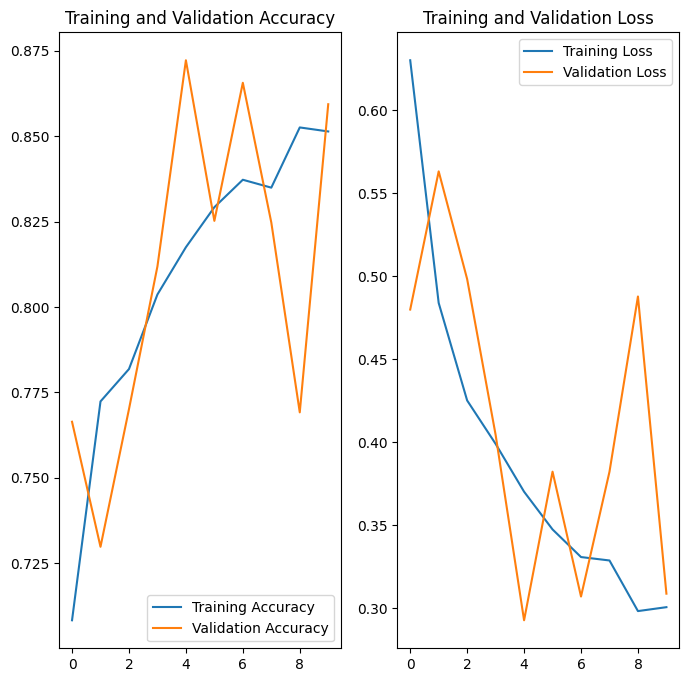

In [9]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=10
epochs_range=range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
score = my_model.evaluate(val_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

52/52 [==============================] - 569s 11s/step - loss: 0.2918 - accuracy: 0.8729
Test loss: 0.29176241159439087
Test accuracy: 0.8729056715965271
